***Библиотеки***

In [ ]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update

# ZDoom dependencies
sudo apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
sudo apt-get install libboost-all-dev

# Python 3 dependencies
sudo apt-get install python3-dev python3-pip
pip3 install numpy
# or install Anaconda 3 and add it to PATH

# Lua binding dependencies
sudo apt-get install liblua5.1-dev
# Lua shipped with Torch can be used instead, so it isn't needed if installing via LuaRocks


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (158 kB/s)
Reading package lists...
Reading package lists...
Building dependency t

In [ ]:
!pip install vizdoom

In [ ]:
!pip install -U -q PyDrive
from google.colab import files
from google.colab import drive

***Модель***

In [ ]:
import torch
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm, trange
import torch.nn.functional as F
import math
import time
from vizdoom import *

batch_size = 32
lr = 0.00025
ram_size = 128
l1_size = 800
flat_size = 31968
l2_size = 128
count_of_actions = 3
tau = 0.05
gamma = 0.99
epsilon = 1
#epsilon = 0.02
epsilon_min = 0.02
epsilon_decay = 0.999
mem_cap = 1000
episodes = 20000
update_interval = 6000
beta_start = 0.4
beta_increment = 0.001
skiprate = 10

if __name__ == '__main__':
    if torch.cuda.is_available():
        print('CUDA is available,',torch.cuda.device_count())
        print(torch.cuda.get_device_name(0))
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class NN(torch.nn.Module):

    def __init__(self):
      super(NN, self).__init__()

      '''
      self.l0 = torch.nn.Linear(ram_size, l1_size)
      self.l1 = torch.nn.Linear(l1_size, l1_size)
      self.l2 = torch.nn.Linear(l1_size, l1_size)
      self.l3 = torch.nn.Linear(l1_size, count_of_actions)
      '''

      self.c0 = torch.nn.Conv2d(3, 32, 7)
      self.p0 = torch.nn.MaxPool2d(2)
      self.c1 = torch.nn.Conv2d(32,32, 4)
      self.p1 = torch.nn.MaxPool2d(2)
      self.l0 = torch.nn.Linear(flat_size, l1_size)
      self.l1 = torch.nn.Linear(l1_size, count_of_actions)

      


    def forward(self, X):
      X = torch.Tensor(X).to(device)
      
      '''
      X = torch.nn.functional.relu(self.l0(X))
      X = torch.nn.functional.relu(self.l1(X))
      X = torch.nn.functional.relu(self.l2(X))
      X = self.l3(X)
      '''

      X = torch.nn.functional.relu(self.p0(self.c0(X)))
      X = torch.nn.functional.relu(self.p1(self.c1(X)))
      X = X.view(X.size(0), -1)
      X = torch.nn.functional.relu(self.l0(X))
      X = self.l1(X)

      return X.cpu()

    def loss(self, prediction, target, weights):
        #return torch.sum(torch.pow(prediction - target, 2), dim = 1) * weights
        #return torch.sum(torch.pow(prediction - target, 2), dim = 1)
        return (torch.FloatTensor(weights) * F.mse_loss(prediction, target))

    def loadWeights(self, path):
      checkpoint = torch.load(path)
      self.load_state_dict(checkpoint, strict = True)

    def saveWeights(self, path):
      torch.save(self.state_dict(), path)

class DQNAgent:
    
    def __init__(self, model, model_next):
        self.epsilon = epsilon
        self.model = model
        self.model_next = model_next
        self.state_memory = np.zeros((mem_cap, 3, 120, 160))
        self.action_memory = np.zeros((mem_cap,)).astype(np.uint16)
        self.reward_memory = np.zeros((mem_cap,))
        self.next_state_memory = np.zeros((mem_cap, 3, 120, 160))
        self.not_done_memory = np.zeros((mem_cap,))
        self.memory_pivot = 0

    def act(self, state):
      with torch.no_grad():
        if np.random.rand(1) < self.epsilon:
          action = np.random.choice(np.arange(count_of_actions), 1)
          return action[0]
        else:
          state = torch.Tensor([state])
          output = self.model(state)
          #print(output)
          max_action = torch.argmax(output, dim = 1)
          return max_action.item()
      
      '''
      state = torch.Tensor([state])
      output = self.model(state)
      max_action = torch.argmax(output, dim = 1)
      return max_action.item()
      '''

    def addToMemory(self, state, action, reward, next_state, not_done):
        index = self.memory_pivot % mem_cap
        self.state_memory[index] = np.asarray(state)
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = np.asarray(next_state)
        self.not_done_memory[index] = not_done
        self.memory_pivot += 1

    def getPAndLoss(self, limiter):

        e = 0.01
        b = np.min([1., beta_start + self.memory_pivot * beta_increment])
        #b = 1.
        a = 0.6

        
        pred = self.model(torch.Tensor(self.state_memory[:limiter]))
        target = pred.clone().detach().numpy()
        with torch.no_grad():
          nextStateOutput, _ = torch.max(self.model_next(self.next_state_memory[:limiter]), dim = 1)
        #nextStateOutput, _ = torch.max(self.model(self.next_state_memory[:limiter]), dim = 1)
        nextStateOutput = nextStateOutput.detach().numpy()
        
        
        all_indexes = np.arange(limiter).astype(np.uint16)
        target[all_indexes, self.action_memory[:limiter]] =  self.reward_memory[:limiter] +\
                                                             gamma * nextStateOutput * self.not_done_memory[:limiter]

        target = torch.Tensor(target)
        TD = torch.pow(torch.sum(torch.abs(pred - target), dim = 1) + e, a)
        p = TD / torch.sum(TD)

        importance = torch.pow(p * limiter, -b)
        importance = importance/torch.max(importance)
        importance = importance.detach()
        
        loss = self.model.loss(pred, target, importance)
        
        #print(loss)

        
        p = p.detach().numpy()
        #p = np.squeeze(p)
        #print(p)

        '''
        if np.isnan(p).any():
          print('FUCK')
          print('mem:',self.memory_pivot)
          
          logical_idx = np.isnan(p)
          print('corrupted num:',np.sum(logical_idx))
          pred = pred.detach().numpy()
          target = target.detach().numpy()

          print('pred:',pred[logical_idx])
          print('target:',target[logical_idx])
          

        if torch.isnan(importance).any():
          print('LOSS FUCK')
          print(p[p<0])
        '''
          

        return p, loss

    def learn(self):
        #st = time.time()


        optimizer.zero_grad()

        limiter = self.memory_pivot - 1 if self.memory_pivot - 1 < mem_cap else mem_cap

        '''
        availableIndexes = np.arange(limiter)
        choosenIndexes = np.random.choice(availableIndexes, batch_size).astype(np.uint16)
        choosenStates = self.state_memory[choosenIndexes]
        choosenActions = self.action_memory[choosenIndexes].astype(np.uint16)
        choosenRewards = self.reward_memory[choosenIndexes]
        choosenNextStates = self.next_state_memory[choosenIndexes]
        choosenNotDone = self.not_done_memory[choosenIndexes]
        

        
        pred = self.model(torch.Tensor(choosenStates))
        target = pred.clone().detach().numpy()
        #nextStateOutput, _ = torch.max(self.model_next(choosenNextStates), dim = 1)
        nextStateOutput, _ = torch.max(self.model(choosenNextStates), dim = 1)
        nextStateOutput = nextStateOutput.detach().numpy()
        
        batch_indexes = np.arange(batch_size)
        target[batch_indexes, choosenActions] = choosenRewards + gamma * nextStateOutput * choosenNotDone #!!!!
        

        target = torch.Tensor(target)
        loss = criterion(pred, target)
        '''

        
        p, loss = self.getPAndLoss(limiter)
        availableIndexes = np.arange(limiter)
        choosenIndexes = np.random.choice(availableIndexes, batch_size, p = p).astype(np.int16)

        loss = loss[choosenIndexes].mean()
        

        l_list.append(loss.item())
        loss.backward()
        optimizer.step()
        '''
        if self.memory_pivot % update_interval:
          print('UPDATE')
          self.hardUpdate()
        '''
        self.softUpdate()
        #print(time.time() - st)
        #self.reset_noise()


    def reset_noise(self):
        """Reset all noisy layers."""
        self.model.noisy_l0.reset_noise()
        self.model_next.noisy_l0.reset_noise()
        

    def softUpdate(self):
      for model_next_param, model_param in zip(self.model_next.parameters(), self.model.parameters()):
            model_next_param.data.copy_(tau* model_param.data + (1.0-tau)*model_next_param.data)

    def hardUpdate(self):
      self.model_next.load_state_dict(self.model.state_dict())

    def decreaseRandomness(self, i, reward):
      
      
      if self.epsilon > epsilon_min:
        self.epsilon *= epsilon_decay
      
      
      '''
      if reward > 0:
          self.epsilon = 1./((i/50)+1)
      '''
      '''
      self.epsilon = 1./((i/50)+1)
      '''

CUDA is available, 1
Tesla P100-PCIE-16GB


***Обучение***

Streaming output truncated to the last 5000 lines.
episode: 15002 reward: 75.0
episode: 15003 reward: 65.0
episode: 15004 reward: 75.0
episode: 15005 reward: 85.0
episode: 15006 reward: 75.0
episode: 15007 reward: 70.0
episode: 15008 reward: 65.0
episode: 15009 reward: 75.0
episode: 15010 reward: 75.0 avg: 71.81818181818181
episode: 15011 reward: 75.0
episode: 15012 reward: 75.0
episode: 15013 reward: 45.0
episode: 15014 reward: 75.0
episode: 15015 reward: 75.0
episode: 15016 reward: 85.0
episode: 15017 reward: 75.0
episode: 15018 reward: 95.0
episode: 15019 reward: 75.0
episode: 15020 reward: 95.0 avg: 76.81818181818181
episode: 15021 reward: 65.0
episode: 15022 reward: 85.0
episode: 15023 reward: 75.0
episode: 15024 reward: 75.0
episode: 15025 reward: 85.0
episode: 15026 reward: 75.0
episode: 15027 reward: 65.0
episode: 15028 reward: 85.0
episode: 15029 reward: 85.0
episode: 15030 reward: 85.0 avg: 79.54545454545455
episode: 15031 reward: 75.0
episode: 15032 reward: 85.0
episode: 150

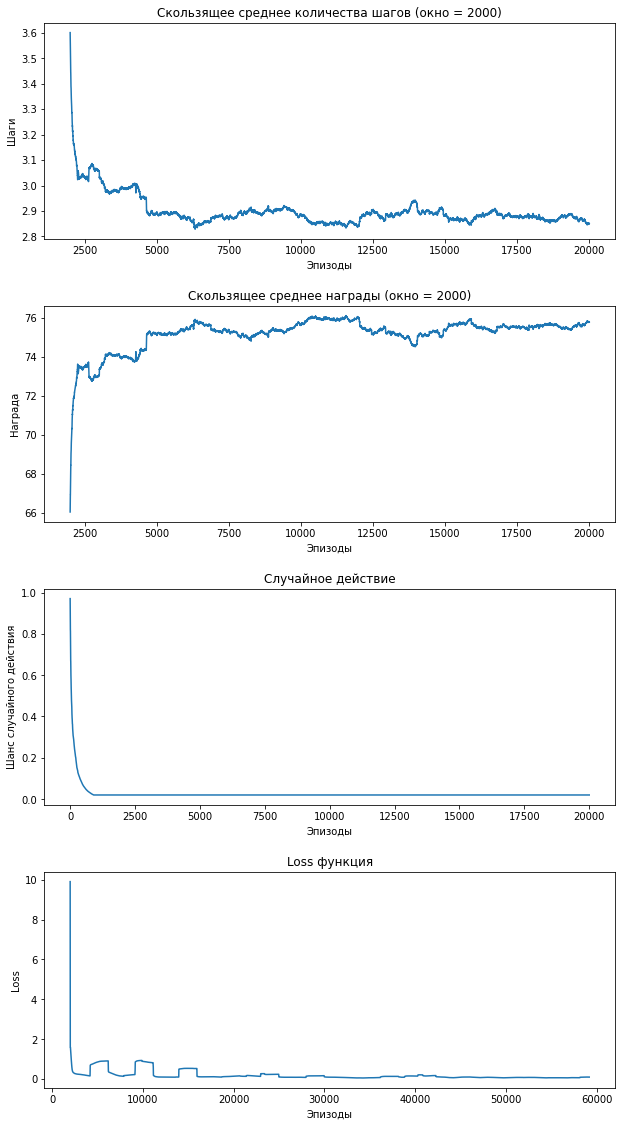

In [ ]:
model = NN().to(device)
#model.loadWeights('./weights/w.pt')
model_next = deepcopy(model)
#model_next = None

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.MSELoss(reduction = 'none')

agent = DQNAgent(model, model_next)

game = DoomGame()
game.load_config("basic.cfg")
game.set_window_visible(False)
game.set_screen_resolution(RES_160X120)
game.init()

shoot = [0, 0, 1]
left = [1, 0, 0]
right = [0, 1, 0]
actions = [shoot, left, right]

rewards = []
steps = []
reward_list = []
step_list = []
e_list = []
l_list = []
succ = 0
steps_taken = 0
for i in range(episodes):
    game.new_episode()
    state = game.get_state()
    state = state.screen_buffer
    reward_sum = 0
    steps_taken = 0
    done = False
    while not done:
        action = agent.act(state)
        #next_state, reward, done, info = game.make_action(actions[action], skiprate)
        reward = game.make_action(actions[action], skiprate)
        done = game.is_episode_finished()
        if done and reward == 100:
            succ += 1
        if not done:
            next_state = game.get_state()
            next_state = next_state.screen_buffer
            agent.addToMemory(state, action, reward, next_state, done == False)
        else:
            agent.addToMemory(state, action, reward, state, done == False)
        if agent.memory_pivot > batch_size:
            agent.learn()
        agent.decreaseRandomness(i, reward)
        reward_sum += reward
        steps_taken += 1
        state = next_state
    reward_list.append(reward_sum)
    step_list.append(steps_taken)
    e_list.append(agent.epsilon)
    if i % 10 == 0 and i != 0:
        print('episode:',i ,'reward:', reward_sum, 'avg:', np.mean(reward_list[i-10:i+1]))
    else:
        print('episode:',i ,'reward:', reward_sum)
    if (i % 1000 == 0 and i!=0) or i == episodes - 1:
        agent.model.saveWeights('./weights/'+str(i)+' '+str(reward)+'.pt')

print(succ/episodes)
window = int(episodes/10)

plt.figure(figsize=[9,16])
plt.subplot(411)
plt.plot(pd.Series(step_list).rolling(window).mean())
plt.title('Скользящее среднее количества шагов (окно = '+str(window)+')')
plt.ylabel('Шаги')
plt.xlabel('Эпизоды')

plt.subplot(412)
plt.plot(pd.Series(reward_list).rolling(window).mean())
plt.title('Скользящее среднее награды (окно = '+str(window)+')')
plt.ylabel('Награда')
plt.xlabel('Эпизоды')

plt.subplot(413)
plt.plot(e_list)
plt.title('Случайное действие')
plt.ylabel('Шанс случайного действия')
plt.xlabel('Эпизоды')

plt.subplot(414)
plt.plot(pd.Series(l_list).rolling(window).mean())
plt.title('Loss функция')
plt.ylabel('Loss')
plt.xlabel('Эпизоды')

plt.tight_layout(pad=2)
plt.show()

***Тест***: Для визуального отображения скачайте билд VizDOOM по [ссылке](https://github.com/mwydmuch/ViZDoom/releases/download/1.1.8pre/ViZDoom-1.1.8pre-Win-Python37-x86_64.zip), а также basic.cfg, basic.wad и желаемый .lmp файл. Перенесите эти три файла на vizdoom.exe.

In [ ]:
#epsilon = 1
epsilon = 0.02


episodes = 5
model = NN().to(device)
model.loadWeights('./weights/w.pt')
model_next = deepcopy(model)
#model_next = None

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.MSELoss(reduction = 'none')

agent = DQNAgent(model, model_next)

game = DoomGame()
game.load_config("basic.cfg")
game.set_episode_timeout(100)
game.set_mode(Mode.PLAYER)
game.set_window_visible(False)
game.set_screen_resolution(RES_160X120)
game.init()

shoot = [0, 0, 1]
left = [1, 0, 0]
right = [0, 1, 0]
actions = [shoot, left, right]


for i in range(episodes):
    game.new_episode(str(i)+'.lmp')
    done = False
    while not done:
        state = game.get_state()
        state = state.screen_buffer
        action = agent.act(state)
        reward = game.make_action(actions[action])
        done = game.is_episode_finished()

game.close()

In [ ]:
import torch
a = torch.Tensor([1,0,0,1])
a[a > 0] = 2
print(a)

tensor([2., 0., 0., 2.])
